<a href="https://colab.research.google.com/github/epv44/rent-vs-buy/blob/main/Mortgage_Cost_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Constants

In [326]:
from dataclasses import dataclass
from datetime import date
from dateutil.relativedelta import relativedelta
from enum import Enum
from typing import Tuple, List

import matplotlib.pyplot as plt
import math
import pandas as pd

!pip install numpy-financial
import numpy_financial as npf

pd.set_option('float_format', '{:,}'.format)

In [327]:
@dataclass
class MortgageData:
    principle_paid: float
    interest_payment: float
    projected_home_value: float
    net_profit_from_home_sale: float
    loan_balance: float
    cash_reserve: float
    # growth of net worth over time after home sale
    net_worth_after_sale: float
    # roi towards your net worth
    roi_net_worth: float
    # roi on the home purchase itself
    roi: float
    # money made after subtracting downpayment
    net_profit: float
    rental_cost: float
    net_worth_if_renting: float
    ds: date


In [328]:
class YearlyRateType(Enum):
    APY = 1
    APR = 2

Derived Monthly Expenses

In [329]:
# yearly interest rate per month
def ownership_costs(
    home_price: float,
    downpayment: float,
    mortgage_interest_rate: float,
    loan_term: float,
    closing_cost_percentage: float,
    property_tax_rate: float,
    should_add_closing_to_loan: bool,
    monthly_pmi: float,
    monthly_hoa: float,
    monthly_insurance: float,
    monthly_maintenance_fund: float,
    periodic_interest_rate: float,
) -> Tuple[float, float, float]:
  payment_periods = loan_term * 12
  loan_amount = home_price - downpayment
  # https://www.nerdwallet.com/article/mortgages/closing-costs-mortgage-fees-explained
  closing_costs = loan_amount * closing_cost_percentage
  down_plus_closing = downpayment + closing_costs
  if should_add_closing_to_loan:
    mortgage = (home_price + closing_costs) - downpayment
  else:
    mortgage = home_price - downpayment

  periodic_mortgage_payment = -1*npf.pmt(
      periodic_interest_rate,payment_periods,mortgage
  )

  monthly_property_tax = home_price * (property_tax_rate/12)

  monthly_operating_expenses = (
      monthly_pmi
      + monthly_hoa
      + monthly_insurance
      + monthly_maintenance_fund
      + periodic_mortgage_payment
      + monthly_property_tax
  )

  return monthly_operating_expenses, periodic_mortgage_payment, down_plus_closing

Monthly Payment Calculation

In [330]:
def calculate_monthly_cost_and_loan_balance(
    monthly_operating_expenses: float,
    down_plus_closing: float,
    periodic_mortgage_payment: float,
    loan_term: float,
    downpayment: float,
    home_price: float,
    property_appreciation: float,
    starting_cash: float,
    realtor_fee_at_sale: float,
    capital_gains_tax: float,
    monthly_rent: float,
    rental_increase_pct: float,
    stock_interest_rate: float,
    monthly_income_saved: float,
    yearly_increase: float,
    purchase_date: date,
    simulation_length_years: int,
    periodic_interest_rate: float,
) -> List[MortgageData]:
  payment_periods = loan_term * 12
  simulation_length_months = simulation_length_years * 12
  loan_amount = home_price - downpayment
  loan_balance = loan_amount
  projected_home_value = home_price
  data = []

  cash_reserve = starting_cash - down_plus_closing

  # rental params
  cash_reserve_rental = starting_cash
  rental_cost_monthly = monthly_rent
  monthly_savings = monthly_income_saved

  for row in range(0, (simulation_length_months)):
    # calc initial payment
    if row == 0:
      interest_payment = loan_amount * periodic_interest_rate
      principle_paid = periodic_mortgage_payment - interest_payment
    elif row <= payment_periods:
      interest_payment = loan_balance * periodic_interest_rate
      principle_paid = periodic_mortgage_payment - interest_payment
    else:
      # at this point the loan is paid off and monthly expenses drop
      principle_paid = 0
      interest_payment = 0
      monthly_operating_expenses = monthly_operating_expenses - periodic_mortgage_payment

    projected_home_value = home_price * (1 + property_appreciation) ** (row/12)
    # if selling at a loss vs. gain
    if projected_home_value - home_price - projected_home_value * realtor_fee_at_sale > 0:
      net_profit_at_sale = (projected_home_value * (1 - realtor_fee_at_sale) - loan_balance) - (
          (projected_home_value - home_price) - projected_home_value * realtor_fee_at_sale
          ) * capital_gains_tax
    else:
      net_profit_at_sale = projected_home_value * (1 - realtor_fee_at_sale) - loan_balance

    net_worth_after_sale = net_profit_at_sale + cash_reserve # - down_plus_closing
    net_profit = net_profit_at_sale # - down_plus_closing
    roi = net_profit / down_plus_closing
    roi_net_worth = (net_profit + cash_reserve) / (down_plus_closing)
    ds = purchase_date + relativedelta(months=row + 1)

    # yearly rent increase
    if row % 12 == 0:
      rental_cost_monthly = rental_cost_monthly * (1 + rental_increase_pct)


    monthly_savings = monthly_income_saved * (1 + yearly_increase) ** (row / 12)

    cash_reserve_rental = cash_reserve_rental * (1 + (stock_interest_rate / 12)) + monthly_savings - rental_cost_monthly

    cash_reserve = cash_reserve * (1 + (stock_interest_rate / 12)) + monthly_savings - monthly_operating_expenses

    loan_balance = loan_balance - principle_paid

    data.append(MortgageData(
        round(principle_paid, 2),
        round(interest_payment, 2),
        round(projected_home_value, 2),
        round(net_profit_at_sale, 2),
        round(loan_balance, 2),
        round(cash_reserve, 2),
        round(net_worth_after_sale, 2),
        roi_net_worth,
        roi,
        round(net_profit, 2),
        round(rental_cost_monthly, 2),
        round(cash_reserve_rental, 2),
        ds
      )
    )

  return data

In [331]:
# shared inputs
home_price = 1700000.0
downpayment = 800000.0
mortgage_interest_rate = .065
loan_term = 30
# APR vs. APY APR does not take into affect compounding thus calculate monthly rate differently
interest_rate_type = YearlyRateType.APR

In [332]:
periodic_interest_rate = (
    mortgage_interest_rate / 12
    if interest_rate_type == YearlyRateType.APY
    else ((1 + mortgage_interest_rate) ** (1 / 12) - 1)
)

# calculations
monthly_operating_expenses, monthly_mortgage, down_plus_closing = ownership_costs(
    home_price=home_price,
    downpayment=downpayment,
    mortgage_interest_rate=mortgage_interest_rate,
    loan_term=loan_term,
    closing_cost_percentage=.025,
    property_tax_rate=.011,
    should_add_closing_to_loan=False,
    monthly_pmi=0.0,
    monthly_hoa=0.0,
    monthly_insurance=490,
    monthly_maintenance_fund=200,
    periodic_interest_rate=periodic_interest_rate,
)

data = calculate_monthly_cost_and_loan_balance(
    monthly_operating_expenses=monthly_operating_expenses,
    down_plus_closing=down_plus_closing,
    periodic_mortgage_payment=monthly_mortgage,
    loan_term=loan_term, # 30, 15, 5 year. Assume fixed rate for now
    downpayment=downpayment,
    home_price=home_price,
    property_appreciation=.04,
    starting_cash=1200000.0,
    realtor_fee_at_sale=.06,
    capital_gains_tax=.3,
    monthly_rent=6500,
    rental_increase_pct=.036,
    stock_interest_rate=.06,
    monthly_income_saved=6500,
    yearly_increase=.02, # in amount saved
    purchase_date=date(2024, 8, 1),
    simulation_length_years=30,
    periodic_interest_rate=periodic_interest_rate,
)

df = pd.DataFrame([vars(s) for s in data])
display(df)

,principle_paid,interest_payment,projected_home_value,net_profit_from_home_sale,loan_balance,cash_reserve,net_worth_after_sale,roi_net_worth,roi,net_profit,rental_cost,net_worth_if_renting,ds
0,843.47,"4,735.52","1,700,000.0","698,000.0","899,156.53","378,060.18","1,075,500.0",1.307598784194529,0.8486322188449849,"698,000.0","6,734.0","1,205,766.0",2024-09-01
1,847.9,"4,731.09","1,705,565.36","704,074.9","898,308.63","378,633.89","1,082,135.08",1.3156657483154495,0.8560181176829037,"704,074.9","6,734.0","1,211,571.57",2024-10-01
2,852.37,"4,726.63","1,711,148.93","710,171.37","897,456.27","379,221.22","1,088,805.26",1.3237753879116172,0.8634302346593661,"710,171.37","6,734.0","1,217,416.91",2024-11-01
3,856.85,"4,722.14","1,716,750.79","716,289.48","896,599.42","379,822.26","1,095,510.7",1.3319279033841693,0.8708686663323694,"716,289.48","6,734.0","1,223,302.26",2024-12-01
4,861.36,"4,717.63","1,722,370.99","722,429.31","895,738.06","380,437.1","1,102,251.58",1.340123496061609,0.8783335096324593,"722,429.31","6,734.0","1,229,227.81",2025-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,"5,434.5",144.49,"5,424,402.1","4,051,796.61","22,025.47","2,519,254.56","6,554,686.94",7.969224242763389,4.92619648102557,"4,051,796.61","18,780.45","5,189,679.61",2054-04-01
356,"5,463.1",115.89,"5,442,160.18","4,068,915.93","16,562.37","2,535,719.9","6,588,170.49",8.00993372899649,4.9470102460509215,"4,068,915.93","18,780.45","5,208,543.95",2054-05-01
357,"5,491.84",87.15,"5,459,976.4","4,086,102.1","11,070.53","2,552,286.88","6,621,822.0",8.050847415339424,4.967905284939103,"4,086,102.1","18,780.45","5,227,521.92",2054-06-01
358,"5,520.74",58.25,"5,477,850.94","4,103,355.39","5,549.79","2,568,956.05","6,655,642.27",8.091966290331,4.988881932872008,"4,103,355.39","18,780.45","5,246,614.14",2054-07-01


In [333]:
print(df['principle_paid'].sum())
print(df['interest_payment'].sum())

899999.98
1108436.66


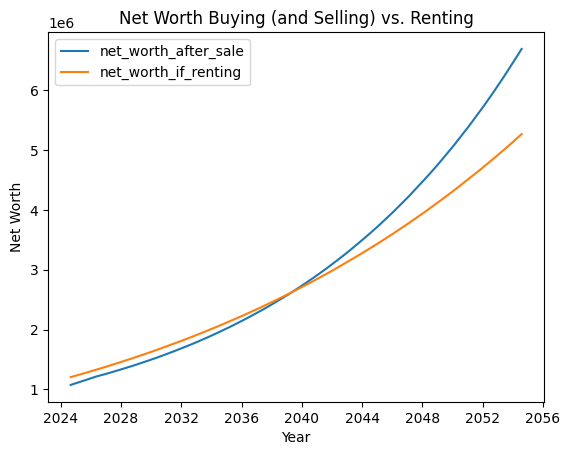

In [338]:
plt.plot('ds', 'net_worth_after_sale', data=df)
plt.plot('ds', 'net_worth_if_renting', data=df)
plt.legend(loc="upper left")
plt.xlabel('Year')
plt.ylabel('Net Worth')
plt.title('Net Worth Buying (and Selling) vs. Renting')
plt.show()

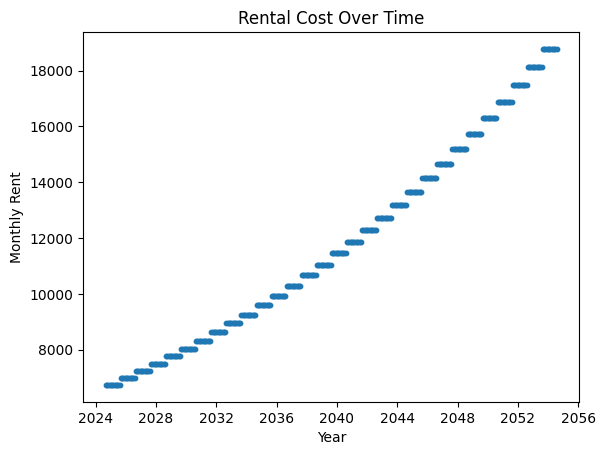

In [335]:
plt.scatter('ds', 'rental_cost', data=df, s=10)
plt.xlabel('Year')
plt.ylabel('Monthly Rent')
plt.title('Rental Cost Over Time')
plt.show()

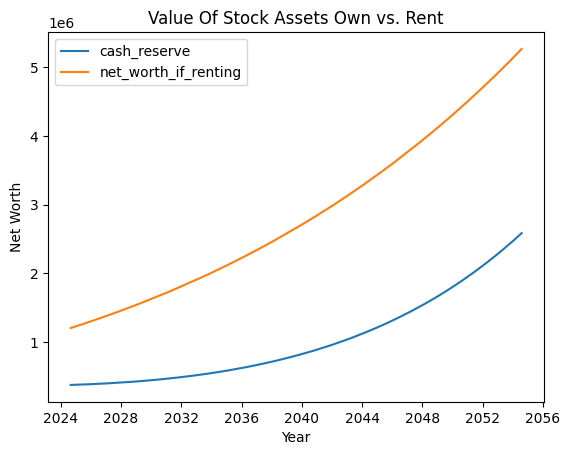

In [339]:
plt.plot('ds', 'cash_reserve', data=df)
plt.plot('ds', 'net_worth_if_renting', data=df)
plt.legend(loc="upper left")
plt.xlabel('Year')
plt.ylabel('Net Worth')
plt.title('Value Of Stock Assets Own vs. Rent')
plt.show()